## Project 1 - Matrix Factorization and Collaborative Filtering
by Telmo Cunha (73487) - 04/04/2022

## Table of contents
1. [Constructing the Ratings Matrix](#1)
2. [Constructing Training & Test Sets](#2)
3. [SVD: Factorization](#3)
4. [SVD: Reconstruction Errors](#4)
5. [SVD: Recommendation System](#5)
6. [SVD: Latent Space Projections](#6)
7. [Algorithm 1: Non-negative Matrix Factorization](#7)
8. [Algorithm 1: Reconstruction Errors](#8)
9. [Algorithm 1: Recommendation System](#9)
10. [Algorithm 1: Latent Space Projections](#10)
11. [NNALS: Factorization](#11)
12. [NNALS: Reconstruction Errors](#12)
13. [NNALS: Recommendation System](#13)
14. [NNALS: Latent Space Projections](#14)

## Constructing the Ratings Matrix <a name="1"></a>

In [1]:
#all necessary libraries
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import time
import random

In [2]:
def read_csv(file_name):
    """
    Input: String with the file name (which should be on the same folder as the notebook).
    Output: List where each entry contains a string of the form "userid, movieid, rating, timestamp".
    """
    
    #utf8 encoding is necessary to properly read characters in the movies.csv file
    with open("./"+file_name, "r",encoding="utf8") as file:
            lines = file.readlines()
            
    return lines

In [3]:
def delete_header(data):
    """
    Input: List read from read_csv().
    Output: The same list with the first element removed, which containts "userid, movieid, rating, timestamp".
    """
    
    del data[0]
    
    return data

In [4]:
def line_split(data):
    """
    Input: List of data
    Output: List of lists by separating the data in each line using ',', i.e. we obtain [[userid], [movieid], [rating], [timestamp]]
    """
    
    data_list=[]
    
    for i in range(0,len(data)):
        data_list.append(data[i].split(','))
        
    return data_list

In [5]:
#This is implemented as a general function, i.e. finds the unique ids for the users. In practice since the original
#file is sorted by user id and includes all users we could just take the last value. 
def counting_user_ids(data):
    """
    Input: List of data after using line_split(). 
    Output: Number of unique users id.
    """
    
    unique_user_ids=[]
    num_ids=0
    
    for i in range(0,len(data)):
        if((data[i][0] in unique_user_ids)==False):
            unique_user_ids.append(data[i][0])
            num_ids+=1
            
    #No need to return the list of unique_user_ids but we could if the users were a subset of a larger set of data
    #and we needed to compare.
            
    return num_ids

In [6]:
def counting_movie_ids(data):
    """
    Input: List of data after using line_split(). 
    Output: Number of unique movie ids and a sorted list with movie ids.
    """
    unique_movie_ids=[]
    num_ids=0
    for i in range(0,len(data)):
            if((int(data[i][1]) in unique_movie_ids)==False):
                unique_movie_ids.append(int(data[i][1]))
                num_ids+=1
                
    #Sort from lowest to highest movie id
    unique_movie_ids=np.sort(unique_movie_ids)
    
    return num_ids, unique_movie_ids

In [7]:
#tag=avg to compute movie avg, skip by default
def generate_R_matrix(num_user_ids,num_movie_ids,data,unique_movies_list,value=0):
    """
    Input: # of user ids, # of movie ids, data after line_split(), list of unique movie ids, value to replace in
    unknown matrix entries, tag to implement average of each movie rated (tag=avg) or tag=skip to use value.
    Ouput: numpy matrix with ratings and value (or movie avg) on missing values .
    """
    
    #initializing with value
    R_matrix=np.full((num_movie_ids,num_user_ids),float(value))
  
    for i in range(0,len(data)):
        index=np.where(unique_movies_list==int(data[i][1]))
        index=int(index[0])
        R_matrix[index,int(data[i][0])-1]=float(data[i][2])

    return R_matrix

In [8]:
def movie_avg(R_matrix_orig):
    """
    Input: Original R_matrix
    Ouput: R_matrix with unknown values replaced by the average rating
    """
    
    R_matrix=np.zeros((num_movie_ids,num_user_ids))

    for i in range(R_matrix_orig.shape[0]):
        
        #this is initiated to 1 to avoid division by zero later when building a train set in case all ratings
        #of a specific movie are removed to a test set
        user_count=1
        sum=0
        for j in range(R_matrix_orig.shape[1]):
            if(R_matrix_orig[i][j]!=0):
                user_count+=1
                sum+=R_matrix_orig[i][j]
            
        R_matrix[i,:]=np.round(float(sum)/user_count,2)
        
    for i in range(R_matrix_orig.shape[0]):
        for j in range(R_matrix_orig.shape[1]):

            if (R_matrix_orig[i][j]!=0):
                R_matrix[i][j]=R_matrix_orig[i][j]
                
    return R_matrix

In [9]:
#test file to test implementation of a smaller matrix (to confirm its working correctly)
#file_name="ratings_test.csv"

file_name="ratings.csv"

data=read_csv(file_name)
data=delete_header(data)
data=line_split(data)

num_user_ids=counting_user_ids(data)
num_movie_ids, unique_movies_list=counting_movie_ids(data)
    
print("Number of user ids: ",num_user_ids)
print("Number of rated movie ids: ",num_movie_ids)
print("Number of data points: ", len(data))

#value=the value which unavailable ratings shall take
value=0.5

#R_matrix_value with unknown values as value
R_matrix_value=generate_R_matrix(num_user_ids,num_movie_ids,data,unique_movies_list,value)

#R_matrix with unknown values as 0, used to check which movies were rated or not
R_matrix_orig=generate_R_matrix(num_user_ids,num_movie_ids,data,unique_movies_list,0)

#R_matrix with unknown values as movie averages
R_matrix_avg=movie_avg(R_matrix_orig)

print ("\nR_orig=\n", R_matrix_orig)
print("-------------------")
print ("\nR_value=\n", R_matrix_value)
print("-------------------")
print ("\nR_avg=\n", R_matrix_avg)

Number of user ids:  610
Number of rated movie ids:  9724
Number of data points:  100836

R_orig=
 [[4.  0.  0.  ... 2.5 3.  5. ]
 [0.  0.  0.  ... 2.  0.  0. ]
 [4.  0.  0.  ... 2.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
-------------------

R_value=
 [[4.  0.5 0.5 ... 2.5 3.  5. ]
 [0.5 0.5 0.5 ... 2.  0.5 0.5]
 [4.  0.5 0.5 ... 2.  0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
-------------------

R_avg=
 [[4.   3.9  3.9  ... 2.5  3.   5.  ]
 [3.4  3.4  3.4  ... 2.   3.4  3.4 ]
 [4.   3.2  3.2  ... 2.   3.2  3.2 ]
 ...
 [1.75 1.75 1.75 ... 1.75 1.75 1.75]
 [1.75 1.75 1.75 ... 1.75 1.75 1.75]
 [2.   2.   2.   ... 2.   2.   2.  ]]


## Constructing Training & Test Sets <a name="2"></a>

In [10]:
def build_sets(data,percentage = 0.1):
    """
    Input: List of data and the percentage of data we want for a test set (default=10%).
    Output: Returns the training set and test set as matrices
    """
    copy_data=data.copy()
    
    test_set=[]
    train_set=[]
    test_number=int(percentage*len(copy_data))
    print("Number of data points in test set:", test_number,"\n")
    
    test_list=random.sample(range(0, len(copy_data)), test_number)
    #print("test_list: ",test_list)
    
    #print ("\ndata: ", copy_data)
    for i in range(0,len(test_list)):
        test_set.append(data[test_list[i]])
        copy_data[test_list[i]]="remove"
    #print ("\ndata: ", copy_data)
    
    for j in range(0,len(copy_data)):
        if copy_data[j]!="remove":
            train_set.append(copy_data[j])

    #change value to filling value if not using movie averages       
    train_set_matrix = generate_R_matrix(num_user_ids,num_movie_ids,train_set,unique_movies_list,value=0)
    test_set_matrix = generate_R_matrix(num_user_ids,num_movie_ids,test_set,unique_movies_list,value=0)
    
    return train_set_matrix, test_set_matrix

## SVD: Factorization <a name="3"></a>

In [11]:
def svd(R_matrix):
    """
    Input: The R_matrix
    Output: SVD factorization matrices (R=USVh), note that s is returned as a vector and not as a diagonal matrix
    """
    
    u, s, vh = np.linalg.svd(R_matrix, full_matrices=False)
    return u, s, vh

In [12]:
def svd_dimreduction(u,s,vh,k):
    """
    Input: Factorization matrices from svd, U, Sigma, VT, and the number of singular values to consider.
    Output: The sliced matrices corresponding to those k values.
    """
    return u[:,0:k],s[0:k],vh[0:k,:]

In [13]:
def rk_reconstruct(u_k,s_k,vh_k):
    """
    Input: Sliced matrices of rank k
    Output: The rank k approximation of R
    """
    s_k=np.diag(s_k)
    return np.matmul(np.matmul(u_k,s_k),vh_k)

In [14]:
def calculate_energy(s,energy_value=0.1):
    """
    Input: s-> diagonal of singular value matrix, energy_value-> fraction of data variance captured
    Ouput: Returns the k value correspoding to a certain energy value.
    """
    total=float(np.sum(s))
    x=0
    k=0
    for j in s:
        x+=j
        k+=1
        if x/total>energy_value:
            break
    return k

## SVD: Reconstruction Errors <a name="4"></a>

In [15]:
#obtain the train and test matrices
train_set_matrix, test_set_matrix=build_sets(data)

#using the movie averages, comment and change value in buil_sets if not the case
train_set_matrix = movie_avg(train_set_matrix)

#perform SVD on the train matrix
u,s,vh=svd(train_set_matrix)
print("R_train=\n",train_set_matrix)
print("------------------------------")
print("R_test=\n",test_set_matrix)

#Confirming high norm value (just to check later results are consistent)
print("\n||R_train_avg-R_matrix_avg|| -> ",np.linalg.norm(np.subtract(train_set_matrix,R_matrix_avg)))

Number of data points in test set: 10083 

R_train=
 [[4.   3.92 3.92 ... 2.5  3.   5.  ]
 [3.4  3.4  3.4  ... 2.   3.4  3.4 ]
 [4.   3.2  3.2  ... 2.   3.2  3.2 ]
 ...
 [1.75 1.75 1.75 ... 1.75 1.75 1.75]
 [1.75 1.75 1.75 ... 1.75 1.75 1.75]
 [2.   2.   2.   ... 2.   2.   2.  ]]
------------------------------
R_test=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

||R_train_avg-R_matrix_avg|| ->  858.3344585299797


In [16]:
def build_comparison_matrices(R_train,R_test):
    """
    Input: R_train and R_test matrices
    Description: Auxiliary function to build matrices for comparison
    Ouput: R_train matrices only with entries corresponding to those on the test set
    """
    
    new_rtrain=np.zeros((num_movie_ids,num_user_ids))
    y=np.transpose(np.nonzero(R_test))

    for i in y:
        new_rtrain[i[0],i[1]]=R_train[i[0],i[1]]
    
    return new_rtrain

In [17]:
#for specific values of k
def svd_convergence_k(R_matrix,u,s,vh):
    """
    Input: R_matrix, and u,s,vh decomposition of R_train
    Ouput: dictionary of the form {rank k,norm_F(Rk_train-R)}
    """

    k_norm_values_dict = {}

    l=np.arange(1,611,1)
    
    for i in l:
        x=0
        u_k,s_k,vh_k = svd_dimreduction(u,s,vh,i)
        Rk_train_matrix=rk_reconstruct(u_k,s_k,vh_k)
        
        #comparison with original matrix, ord='fro' -> frobenius norm, ord='nuc' -> nuclear norm 
        x=np.linalg.norm(np.subtract(Rk_train_matrix,R_matrix),ord='fro')
        
        print("k=",i,"done!")

        k_norm_values_dict[i] = round(x,1)
          
    return k_norm_values_dict

In [18]:
#for specific values of k
def testset_comparison_k(R_test,u,s,vh):
    """
    Input: R_matrix, R_test and u,s,vh decomposition of R_train
    Ouput: dictionary of the form {rank k,norm_F(Rk_train-R_test)}
    """
    
    k_norm_values_dict = {}

    l=np.arange(1,611,1)
    
    for i in l:
        x=0
        u_k,s_k,vh_k = svd_dimreduction(u,s,vh,i)
        Rk_train_matrix=rk_reconstruct(u_k,s_k,vh_k)
        Rk_train_matrix=build_comparison_matrices(Rk_train_matrix,R_test)
        Rk_train_matrix=np.round(Rk_train_matrix,1)
        
        #change ord for different norms
        x=np.linalg.norm(np.subtract(Rk_train_matrix,R_test),ord='fro')
        
        k_norm_values_dict[i] = round(x,1)
        
        print("k=",i,"done!")
          
    return k_norm_values_dict 

### Remove comments on the following two code cells to compute plots

In [19]:
##we can input R_matrix_avg/R_matrix/R_matrix_orig but we have to manually alter value on the buildsets function
#dic0=svd_convergence_k(train_set_matrix,u,s,vh)
#dic1=testset_comparison_k(test_set_matrix,u,s,vh)
#print("Norm min for test:","k=", min(dic1, key=dic1.get), " norm=", dic1[min(dic1, key=dic1.get)])

### Plot for f=movie_avg (separated graphs)

In [20]:
##plot specifications
#x=list(dic0.keys())
#y=list(dic0.values())
#fig, (ax1, ax2) = plt.subplots(2)
#fig.set_size_inches(18.5, 10.5)
##fig.figure(figsize=(20, 10))
#ax1.plot(x, y)
#plt.xlabel('rank(k)')  # Add an x-label to the axes.
#plt.xticks(np.arange(min(x)-1, 610, 20.0))
#plt.ylabel('Norm(k)')  # Add a y-label to the axes.
#plt.title("Frobenius norm as a function of rank; f = movie_avg")  # Add a title to the axes.
##plt.title("Nuclear norm as a function of rank")  # Add a title to the axes.
#x=list(dic1.keys())
#y=list(dic1.values())
#ax2.plot(x, y)

### Plot for f=0.5 (both graphs)

In [21]:
#x=list(dic0.keys())
#y=list(dic0.values())
#plt.figure(figsize=(20, 10))
#plt.plot(x, y)
#plt.xlabel('rank(k)')  # Add an x-label to the axes.
#plt.xticks(np.arange(0, 621, 20))
#plt.ylabel('Norm(k)')  # Add a y-label to the axes.
#plt.title("Frobenius norm as a function of rank; f = movie_avg")  # Add a title to the axes.
#x=list(dic1.keys())
#y=list(dic1.values())
##plt.plot(x, y)

### For specific energy values:

In [22]:
#energy based calculations (not actually necessary)
def svd_convergence(R_matrix,u,s,vh):
    """
    Input: R_matrix, test_set_matrix and u,s,vh decomposition of R_train
    Ouput: dictionary of the form {rank k,norm_F(Rk_train-R_matrix) for significance values in 0.1 increments}
    """

    k_norm_values_dict = {}

    l=np.arange(0.1,1.1,0.1)
    
    for i in l:
        x=0
        k=calculate_energy(s,energy_value=i)
        u_k,s_k,vh_k = svd_dimreduction(u,s,vh,k)
        Rk_train_matrix=rk_reconstruct(u_k,s_k,vh_k)
        #print("Rk_train:\n", np.matrix.round(Rk_train_matrix,2))
        
        #comparison with original matrix
        x=np.linalg.norm(np.subtract(Rk_train_matrix,R_matrix))
    
        k_norm_values_dict[k] = round(x,1)
    
        print("For rank =", k , ", corresponding to",round(i,1),"significance of the data, we have:" , "Norm = ", round(x,1))
        
    return k_norm_values_dict

In [23]:
#energy based calculations (not actually necessary)
def testset_comparison(R_matrix,test_set_matrix,u,s,vh):
    """
    Input: R_matrix, test_set_matrix and u,s,vh decomposition of R_train
    Ouput: dictionary of the form {rank k,norm_F(Rk_train-R_test) for significance values in 0.1 increments}
    """

    k_norm_values_dict = {}

    l=np.arange(0.1,1.1,0.1)
    
    for i in l:
        x=0
        k=calculate_energy(s,energy_value=i)
        u_k,s_k,vh_k = svd_dimreduction(u,s,vh,k)
        Rk_train_matrix=rk_reconstruct(u_k,s_k,vh_k)
        
        #comparing entries with test set
        y=np.transpose(np.nonzero(test_set_matrix))
        for j in y:

            x+=np.power(test_set_matrix[j[0],j[1]]-Rk_train_matrix[j[0],j[1]],2)
        x=np.sqrt(x)
        
        #print("Norm of test matrix:", np.linalg.norm(test_set_matrix))
        k_norm_values_dict[k] = round(x,1) 
        print("For rank =", k , ", corresponding to",round(i,1),"significance of the data, we have:" , "Norm = ", round(x,1))
        
    return k_norm_values_dict 

In [24]:
#dict1=svd_convergence(R_matrix_avg,u,s,vh)
#print("---------------------------------------------------------------")
#dict2=testset_comparison(R_matrix_avg,test_set_matrix,u,s,vh)

In [25]:
#x=list(dict1.keys())
#y=list(dict1.values())
#plt.plot(x, y)
#plt.xlabel('rank(k)')  # Add an x-label to the axes.
#plt.ylabel('Norm(k)')  # Add a y-label to the axes.
#plt.title("Frobenius norm as a function of rank")  # Add a title to the axes.
#
#x=list(dict2.keys())
#y=list(dict2.values())
#plt.plot(x, y)
#plt.xlabel('rank(k)')  # Add an x-label to the axes.
#plt.ylabel('Norm(k)')  # Add a y-label to the axes.
#plt.title("Frobenius norm as a function of rank")  # Add a title to the axes.

## SVD: Recommendation System <a name="5"></a>

In [26]:
#IMPORTANT REMARK: Since there are movie names with commas (,) we formatted the original csv file to replace the commas with .
#since this causes a conflict with the commas separating column values when reading a csv.
#The anexed movies.csv should be used.

file_name="movies.csv"
movie_list=read_csv(file_name)
movie_list=delete_header(movie_list)
movie_list=line_split(movie_list)

In [27]:
# we use cosine similarity since we are interested on those movies which have the same direction
# in the latent space
def cosine_sim(a,b):
    """
    Input: two vectors (a,b)
    Ouput: returns cos theta=<a.b>/(||a||.||b||)
    """
    
    norm_a=np.linalg.norm(a)
    norm_b=np.linalg.norm(b)
    
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [28]:
def recommend_movies_based_on_movie_svd(movie_id,R_matrix,unique_movies_list):
    """
    Input: movie_id we want to compare, R_matrix, list with index-movie id correspondence
    Ouput: None, however the function prints the top 10 results similar to movie id
    """
    
    u, s, vh = svd(R_matrix)
    
    #using the best rank k obtained from previous analysis for SVD
    k=12
    u_k,s_k,vh_k = svd_dimreduction(u,s,vh,k)
    
    #multiply u_k with s_k most likely
    
    sim = np.zeros(shape=(num_movie_ids,2))
    movie_id_index=np.where(unique_movies_list==movie_id)
    movie_id_index=int(movie_id_index[0])
    
    for i in range(num_movie_ids):
        sim[i][0]=cosine_sim(u_k[movie_id_index,:],u_k[i,:])
        sim[i][1]=unique_movies_list[i]
    
    #sorts from lowest to highest
    sim=sim[sim[:, 0].argsort()]
    
    for i in range(len(movie_list)):
        if(int(movie_list[i][0])==movie_id):
            print("\nRecommendations similar to:", movie_list[i][1])
    
    for i in range(11):
        for j in range(len(movie_list)):
            #we use sim.shape[0]-(1+i) because sort was lost to high
            if(int(sim[sim.shape[0]-(1+i)][1])== int(movie_list[j][0])):
                if(i==0):
                    print("")
                    #print("Printing highest to confirm it's working as intended:",movie_list[j][1],"Similarity:", np.round(sim[sim.shape[0]-(1+i)][0],2))
                elif (i>0):
                    print(i,')', movie_list[j][1],"Similarity:", np.round(sim[sim.shape[0]-(1+i)][0],2))
    return None

### Recommendation for movies

In [29]:
#TESTS
#The Matrix
#recommend_movies_based_on_movie_svd(2571,R_matrix_avg,unique_movies_list)
#Lord of the Rings: The Fellowship of the Ring
recommend_movies_based_on_movie_svd(4993,R_matrix_avg,unique_movies_list)
#Pulp Fiction
#recommend_movies_based_on_movie_svd(296,R_matrix_avg,unique_movies_list)


Recommendations similar to: Lord of the Rings: The Fellowship of the Ring. The (2001)

1 ) Lord of the Rings: The Two Towers. The (2002) Similarity: 0.96
2 ) Lord of the Rings: The Return of the King. The (2003) Similarity: 0.88
3 ) Memento (2000) Similarity: 0.85
4 ) Lemony Snicket's A Series of Unfortunate Events (2004) Similarity: 0.84
5 ) District 9 (2009) Similarity: 0.82
6 ) Number 23. The (2007) Similarity: 0.82
7 ) Seven (a.k.a. Se7en) (1995) Similarity: 0.8
8 ) Zootopia (2016) Similarity: 0.78
9 ) Rise of the Planet of the Apes (2011) Similarity: 0.78
10 ) Iron Man 3 (2013) Similarity: 0.76


In [30]:
#Star Wars: Episode IV - A New Hope (1977) - sic-fi/many sequels - average vs specific value
#R_matrix_avg
recommend_movies_based_on_movie_svd(260,R_matrix_avg,unique_movies_list)


Recommendations similar to: Star Wars: Episode IV - A New Hope (1977)

1 ) Star Wars: Episode V - The Empire Strikes Back (1980) Similarity: 0.96
2 ) Star Wars: Episode VI - Return of the Jedi (1983) Similarity: 0.94
3 ) Die Hard (1988) Similarity: 0.89
4 ) Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Similarity: 0.85
5 ) Gladiator (2000) Similarity: 0.8
6 ) Austin Powers: The Spy Who Shagged Me (1999) Similarity: 0.79
7 ) Bug's Life. A (1998) Similarity: 0.77
8 ) Seven (a.k.a. Se7en) (1995) Similarity: 0.77
9 ) Indiana Jones and the Last Crusade (1989) Similarity: 0.77
10 ) Flintstones in Viva Rock Vegas. The (2000) Similarity: 0.76


In [31]:
def recommend_movies_based_on_user_svd(user_id,R_matrix_orig,R_matrix,unique_movies_list):
    """
    Input: user_id we want to predict ratings, R_matrix, list with index-movie id correspondence
    Ouput: None, however the function prints the top 10 movies for user with user_id
    """
    
    u, s, vh = svd(R_matrix)
    
    #using the best rank k obtained from previous analysis for SVD
    k=9
    u_k,s_k,vh_k = svd_dimreduction(u,s,vh,k)
    Rk=rk_reconstruct(u_k,s_k,vh_k)
    
    #2d list with ratings obtained from Rk and corresponding movie index
    ratings_movieid=np.zeros(shape=(num_movie_ids,2))
    
    for i in range(num_movie_ids):
        #record only unseen movies, i.e. 0 rating on original R matrix
        if(R_matrix_orig[i][user_id-1]==0):
            ratings_movieid[i][0]=Rk[i][user_id-1]
            #getting movie id from index using unique_movies_list
            ratings_movieid[i][1]=unique_movies_list[i]
    
    ratings_movieid=ratings_movieid[ratings_movieid[:, 0].argsort()]
    
    print("Expected ratings for user:",user_id)
    
    for i in range(10):
        for j in range(len(movie_list)):
            if(int(ratings_movieid[ratings_movieid.shape[0]-(i+1)][1])== int(movie_list[j][0])):     
                print(i+1,':', movie_list[j][1], "-> Expected rating:",np.round(ratings_movieid[ratings_movieid.shape[0]-(i+1)][0],2))
                
    return None

### Recommendation for user

In [32]:
#Note that expected ratings may have a rating larger than 5
recommend_movies_based_on_user_svd(134,R_matrix_orig,R_matrix_avg,unique_movies_list)

Expected ratings for user: 134
1 : Shawshank Redemption. The (1994) -> Expected rating: 4.42
2 : Streetcar Named Desire. A (1951) -> Expected rating: 4.27
3 : Godfather. The (1972) -> Expected rating: 4.26
4 : Fight Club (1999) -> Expected rating: 4.24
5 : Godfather: Part II. The (1974) -> Expected rating: 4.22
6 : Goodfellas (1990) -> Expected rating: 4.22
7 : Three Billboards Outside Ebbing. Missouri (2017) -> Expected rating: 4.22
8 : Usual Suspects. The (1995) -> Expected rating: 4.22
9 : Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) -> Expected rating: 4.21
10 : Secrets & Lies (1996) -> Expected rating: 4.21


## SVD: Latent Space Projections <a name="6"></a>

In [33]:
def latent_space_proj_svd(n,R_matrix,unique_movies_list):
    """
    Input: n-> number of movies, R_matrix, unique_movies_list
    Ouput: Returns the coords of each movie (for latent space of dim2) and the corresponding movie id
    in two separate lists
    """
    
    #x-coordinate sigma1
    #y-coordinate sigma2
        
    u,s,vh = svd(R_matrix)
    
    k=12
    u_k,s_k,vh_k = svd_dimreduction(u,s,vh,k)
    
    M=u_k
    
    #generate indices of movies
    l=np.arange(0,num_movie_ids)
    l=np.ndarray.tolist(l)
    
    #contains the coords of 100 movies
    movies_coords=np.zeros(shape=(n,2))
    
    #Draw n random movies
    movie_indices=random.sample(l,n)

    movie_indices.sort()
    
    j=0
    for i in movie_indices:
        movies_coords[j][0]=M[i][0]
        movies_coords[j][1]=M[i][1]
        j+=1
        
    #recover movie ids from indices
    movie_ids=[]
    for i in movie_indices:
        movie_ids.append(unique_movies_list[i])
        
    return movies_coords, movie_ids

#### Plot of Latent Space for SVD (random)

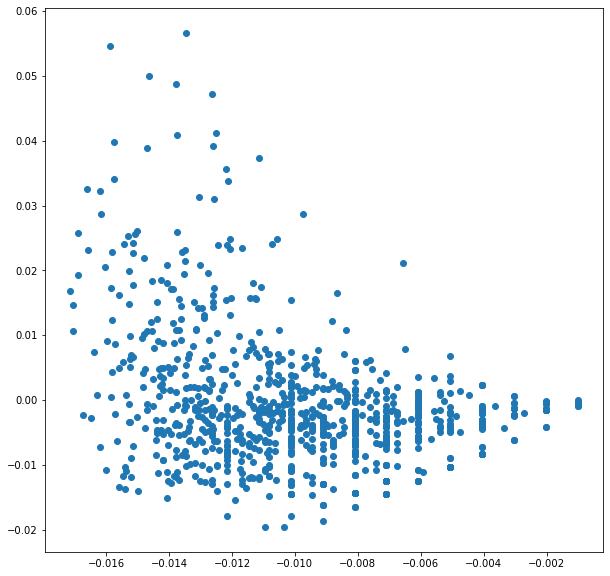

In [34]:
#n-> number of movies to plot
n=1000

#R_matrix_avg/R_matrix_value/R_matrix_orig
movie_coords,movie_ids=latent_space_proj_svd(n,R_matrix_avg,unique_movies_list)
plt.figure(figsize=(10, 10))
plt.scatter(movie_coords[:,0], movie_coords[:,1])

##prints movie names on points
#for i in range(movie_coords.shape[0]):
#    for j in range(len(movie_list)):
#        if(movie_list[j][0]==str(movie_ids[i])):
#            index=j
#    plt.text(movie_coords[i][0],movie_coords[i][1],movie_list[index][1])

In [35]:
def latent_space_proj_svd_test(R_matrix,unique_movies_list):
    """
    Input: n-> number of movies, R_matrix, unique_movies_list
    Ouput: Returns the coords of each movie (for latent space of dim2) and the corresponding movie id
    in two separate lists
    """
    
    u,s,vh = svd(R_matrix)
    
    k=12
    u_k,s_k,vh_k = svd_dimreduction(u,s,vh,k)
    
    M=u_k
    
    #change here the number of movies
    n=14
    movies_coords=np.zeros(shape=(n,2))
                           
    movie_ids=[]
    
    ###########################################################################
    #Defining specific movies for interpretation
    
    #sci-fi / fantasy
    #Blade Runner (1982)
    movie_ids.append(541)
    #Star Wars: Episode V - The Empire Strikes Back (1980)
    movie_ids.append(1196)
    #Matrix. The (1999)                       
    movie_ids.append(2571)
    #Lord of the Rings: The Fellowship of the Ring. The (2001)                     
    movie_ids.append(4993)
    #Lord of the Rings: The Two Towers. The (2002)                       
    movie_ids.append(5952)
    #Lord of the Rings: The Return of the King. The (2003)                       
    movie_ids.append(7153)
    
    #nonfiction
    #Dead Man Walking (1995)
    movie_ids.append(36)
    #Three Billboards Outside Ebbing. Missouri (2017)
    movie_ids.append(177593)
    
    #horror movies
    #The Shining (1997)                       
    movie_ids.append(180263)
    #Babadook. The (2014)                       
    movie_ids.append(112515)
    #Candyman: Farewell to the Flesh (1995)
    movie_ids.append(606)
    
    #dramas/romance
    #Pride and Prejudice (1995)
    movie_ids.append(7669)
    #Titanic (1997)
    movie_ids.append(1721)
    
    #comedy/animation
    #Ice Age (2002)
    movie_ids.append(5218)
    ###########################################################################
    
    
    #get indices from movie ids
    movie_index=[]
    
    for i in movie_ids:
        movie_index.append(int(np.where(unique_movies_list==i)[0]))

    j=0
    for i in movie_index:
        movies_coords[j][0]=M[i][0]
        movies_coords[j][1]=M[i][1]
        j+=1
    
    return movies_coords, movie_ids

#### Plot of Latent Space for SVD (not-random)

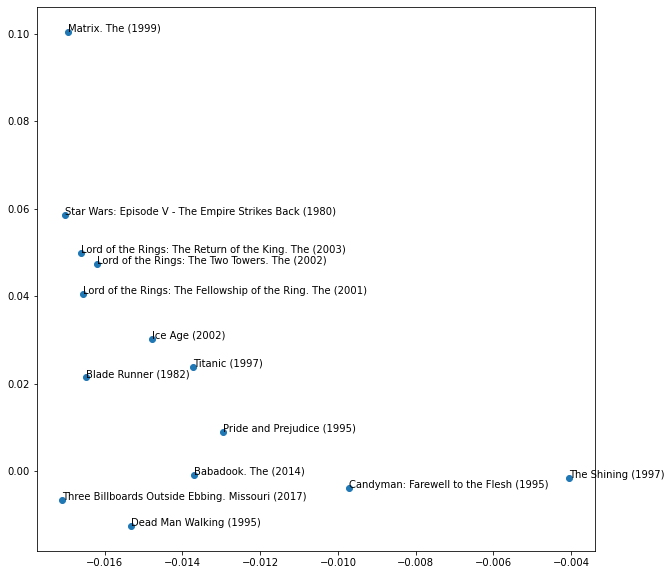

In [36]:
movie_coords,movie_ids=latent_space_proj_svd_test(R_matrix_avg,unique_movies_list)

plt.figure(figsize=(10, 10))
plt.scatter(movie_coords[:,0], movie_coords[:,1])

#prints movie names on points
for i in range(movie_coords.shape[0]):
    for j in range(len(movie_list)):
        if(movie_list[j][0]==str(movie_ids[i])):
            index=j
    plt.text(movie_coords[i][0],movie_coords[i][1],movie_list[index][1])

## Algorithm 1: Non-negative Matrix Factorization <a name="7"></a>

In [37]:
#remove division by zero warnings
np.seterr(divide='ignore', invalid='ignore')
def nnmf(R_train,k):
    """
    Input: R_train (training matrix) and rank k (dim of latent space)
    Ouput: Returns the factorization matrices M,U (R~MU)
    """
    
    a=time.time()
    
    M=np.random.random((R_train.shape[0],k))
    U=np.random.random((k,R_train.shape[1]))
    
    err=10
    c=0
    
    R0=np.matmul(M,U)
    
    #lower errors results in really long times for convergence
    while(err>2):
        
        #due to possible division by "0" we must replace nan values
        A1=np.matmul(M.T,R_train)
        A2=np.matmul(M.T,np.matmul(M,U))
        X1=np.divide(A1,A2)
        X1=np.nan_to_num(X1,nan=1.0)
        
        U=np.multiply(U,X1)
        
        #due to possible division by "0" we must replace nan values
        B1=np.matmul(R_train,U.T)
        B2=np.matmul(M,np.matmul(U,U.T))
        X2=np.divide(B1,B2)
        X2=np.nan_to_num(X2,nan=1.0)   
        
        M=np.multiply(M,X2)
        
        R1=np.matmul(M,U)
        Z=np.subtract(R1,R0)
        err=np.linalg.norm(Z,ord='fro')

        R0=R1
        c+=1
     
    b=time.time()-a
    print("Number of iterations: ", c)
    print("Time taken: ", b)

    return M,U

## Algorithm 1: Reconstruction Errors<a name="8"></a>

In [38]:
def nnmf_test(R_train,R_test,R_matrix):
    """
    Input: R_train (training matrix), R_test (test matrix) and original matrix R
    Ouput: Returns two dicts, first with Norm_F(Rk-R) and second with Norm_F(Rk-R_test) and corresponding k
    """
    
    nnmf_dict1 = {}
    nnmf_dict2 = {}
    
    #Change ord for different norms
    
    for i in range(1,50,1):
        M,U=nnmf(R_train,i)
        R_approx=np.matmul(M,U)
        x=np.linalg.norm(np.subtract(R_approx,R_matrix),ord='fro')
        R_approx_comp=build_comparison_matrices(R_approx,R_test)
        y=np.linalg.norm(np.subtract(R_approx_comp,R_test),ord='fro')   
        nnmf_dict1[i] = round(x,1)
        nnmf_dict2[i] = round(y,1)
        print("Rank k =",i,"done.")
        print("---------------")
        
    for i in range(50,301,10):
        M,U=nnmf(R_train,i)
        R_approx=np.matmul(M,U)
        x=np.linalg.norm(np.subtract(R_approx,R_matrix),ord='fro')
        R_approx_comp=build_comparison_matrices(R_approx,R_test)
        y=np.linalg.norm(np.subtract(R_approx_comp,R_test),ord='fro')   
        nnmf_dict1[i] = round(x,1)
        nnmf_dict2[i] = round(y,1)
        print("Rank k =",i,"done.")
        print("---------------")
        
    return nnmf_dict1,nnmf_dict2

### Remove comments on the following two code cells to compute plots

In [39]:
#nnmf_dic1,nnmf_dic2=nnmf_test(train_set_matrix,test_set_matrix,train_set_matrix)

In [40]:
#print("Norm min for test:","k=", min(nnmf_dic2, key=nnmf_dic2.get), " norm=", nnmf_dic2[min(nnmf_dic2, key=nnmf_dic2.get)])
#x=list(nnmf_dic1.keys())
#y=list(nnmf_dic1.values())
#plt.figure(figsize=(20, 10))
##plt.plot(x, y)
#plt.xlabel('rank(k)')  # Add an x-label to the axes.
#plt.xticks(np.arange(0, 310, 20))
#plt.ylabel('Norm(k)')  # Add a y-label to the axes.
#plt.title("Frobenius norm as a function of rank")  # Add a title to the axes.
#x=list(nnmf_dic2.keys())
#y=list(nnmf_dic2.values())
#plt.plot(x, y)

In [41]:
#confirming results of nnmf_test() using sklearn non_negative_factorization()

from sklearn.decomposition import non_negative_factorization
def nnmf_sk():

    nnmfdict1={}
    nnmfdict2={}
    for i in range (1,51,1):
        W, H, n_iter = non_negative_factorization(train_set_matrix, n_components=i,init='random', random_state=0)
        WH=np.matmul(W,H)
        nnmfdict1[i]=round(np.linalg.norm(np.subtract(WH,train_set_matrix),ord='nuc'),2)
        WH_comp=build_comparison_matrices(WH,test_set_matrix)
        nnmfdict2[i]=round(np.linalg.norm(np.subtract(WH_comp,test_set_matrix),ord='nuc'),2)
        print("Run:",i)
        
    for i in range (60,311,10):
        W, H, n_iter = non_negative_factorization(train_set_matrix, n_components=i,init='random', random_state=0)
        WH=np.matmul(W,H)
        nnmfdict1[i]=round(np.linalg.norm(np.subtract(WH,train_set_matrix),ord='nuc'),2)
        WH_comp=build_comparison_matrices(WH,test_set_matrix)
        nnmfdict2[i]=round(np.linalg.norm(np.subtract(WH_comp,test_set_matrix),ord='nuc'),2)
        print("Run:",i)
        
    return nnmfdict1, nnmfdict2

### Remove comments on the following two code cells to compute plots

In [42]:
#nnmfdict1, nnmfdict2=nnmf_sk()

In [43]:
#print("Norm min for test:","k=", min(nnmfdict2, key=nnmfdict2.get), " norm=", nnmfdict2[min(nnmfdict2, key=nnmfdict2.get)])
#x=list(nnmfdict1.keys())
#y=list(nnmfdict1.values())
#plt.figure(figsize=(20, 10))
##plt.plot(x, y)
#plt.xlabel('rank(k)')  # Add an x-label to the axes.
#plt.xticks(np.arange(0, 330, 20))
#plt.ylabel('Norm(k)')  # Add a y-label to the axes.
#plt.title("Frobenius norm as a function of rank")  # Add a title to the axes.
#x=list(nnmfdict2.keys())
#y=list(nnmfdict2.values())
#plt.plot(x, y)

## Algorithm 1: Recommendation System <a name="9"></a>

In [44]:
def recommend_movies_based_on_movie_nnmf(movie_id,R_matrix,unique_movies_list):
    """
    Input: movie_id we want to compare, R_matrix, list with index-movie id correspondence
    Ouput: None, however the function prints the top 10 results similar to movie id
    """
    
    #sk function
    k=16
    M,U, n_iter = non_negative_factorization(R_matrix, n_components=k,init='random', random_state=0)
    
    #nnmf function
    #k=13
    #M,U=nnmf(R_matrix,k)
    
    sim = np.zeros(shape=(num_movie_ids,2))
    movie_id_index=np.where(unique_movies_list==movie_id)
    movie_id_index=int(movie_id_index[0])
    
    for i in range(num_movie_ids):
        sim[i][0]=cosine_sim(M[movie_id_index,:],M[i,:])
        sim[i][1]=unique_movies_list[i]
    
    #sorts from lowest to highest
    sim=sim[sim[:, 0].argsort()]
    
    for i in range(len(movie_list)):
        if(int(movie_list[i][0])==movie_id):
            print("\nRecommendations similar to:", movie_list[i][1])
    
    for i in range(11):
        for j in range(len(movie_list)):
            #we use sim.shape[0]-(1+i) because sort was lost to high
            if(int(sim[sim.shape[0]-(1+i)][1])== int(movie_list[j][0])):
                if(i==0):
                    print("")
                    #print("Printing highest to confirm it's working as intended:",movie_list[j][1],"Similarity:", np.round(sim[sim.shape[0]-(1+i)][0],2))
                elif (i>0):
                    print(i,')', movie_list[j][1],"Similarity:", np.round(sim[sim.shape[0]-(1+i)][0],2))
    return None

### Recommendation for movies

In [45]:
#Lord of the Rings: The Fellowship of the Ring
recommend_movies_based_on_movie_nnmf(4993,R_matrix_avg,unique_movies_list)

C:\Users\telmo\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"



Recommendations similar to: Lord of the Rings: The Fellowship of the Ring. The (2001)

1 ) Lord of the Rings: The Two Towers. The (2002) Similarity: 1.0
2 ) Lord of the Rings: The Return of the King. The (2003) Similarity: 0.99
3 ) Incredibles. The (2004) Similarity: 0.98
4 ) Spider-Man 2 (2004) Similarity: 0.98
5 ) Fifth Element. The (1997) Similarity: 0.98
6 ) Mask of Zorro. The (1998) Similarity: 0.98
7 ) X2: X-Men United (2003) Similarity: 0.98
8 ) Spider-Man (2002) Similarity: 0.97
9 ) Memento (2000) Similarity: 0.97
10 ) Silence of the Lambs. The (1991) Similarity: 0.97


In [46]:
def recommend_movies_based_on_user_nnmf(user_id,R_matrix_orig,R_matrix,unique_movies_list):
    """
    Input: user_id we want to predict ratings, R_matrix, list with index-movie id correspondence
    Ouput: None, however the function prints the top 10 movies for user with user_id
    """
    
    #nnmf function
    #k=13
    #M,U=nnmf(R_matrix,k)
    #Rk=np.matmul(M,U)
    
    #sk function
    k=16
    M,U, n_iter = non_negative_factorization(R_matrix, n_components=k,init='random', random_state=0)
    Rk=np.matmul(M,U)
    
    #2d list with ratings obtained from Rk and corresponding movie index
    ratings_movieid=np.zeros(shape=(num_movie_ids,2))
    
    for i in range(num_movie_ids):
        #record only unseen movies, i.e. 0 rating on original R matrix
        if(R_matrix_orig[i][user_id-1]==0):
            ratings_movieid[i][0]=Rk[i][user_id-1]
            #getting movie id from index using unique_movies_list
            ratings_movieid[i][1]=unique_movies_list[i]
    
    ratings_movieid=ratings_movieid[ratings_movieid[:, 0].argsort()]
    
    print("\nExpected ratings for user:",user_id)
    
    for i in range(10):
        for j in range(len(movie_list)):
            if(int(ratings_movieid[ratings_movieid.shape[0]-(i+1)][1])== int(movie_list[j][0])):     
                print(i+1,':', movie_list[j][1], "-> Expected rating:",np.round(ratings_movieid[ratings_movieid.shape[0]-(i+1)][0],2))
                
    return None

### Recommendation for user

In [47]:
#user 134
recommend_movies_based_on_user_nnmf(134,R_matrix_orig,R_matrix_avg,unique_movies_list)


Expected ratings for user: 134
1 : Shawshank Redemption. The (1994) -> Expected rating: 4.54
2 : Matrix. The (1999) -> Expected rating: 4.42
3 : Star Wars: Episode IV - A New Hope (1977) -> Expected rating: 4.4
4 : Godfather. The (1972) -> Expected rating: 4.37
5 : Schindler's List (1993) -> Expected rating: 4.35
6 : Star Wars: Episode V - The Empire Strikes Back (1980) -> Expected rating: 4.31
7 : Fight Club (1999) -> Expected rating: 4.3
8 : Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) -> Expected rating: 4.27
9 : Apocalypse Now (1979) -> Expected rating: 4.26
10 : Princess Bride. The (1987) -> Expected rating: 4.26


C:\Users\telmo\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## Algorithm 1: Latent Space Projections <a name="10"></a>

In [48]:
def latent_space_proj_a1(n,R_matrix,unique_movies_list):
    """
    Input: n-> number of movies, R_matrix, unique_movies_list
    Ouput: Returns the coords of each movie (for latent space of dim2) and the corresponding movie id
    in two separate lists
    """
    
    #x-coordinate sigma1
    #y-coordinate sigma2
    
    #nnmf function
    #k=13
    #M,U=nnmf(R_matrix,k)
    
    #sk function
    k=16
    M,U, n_iter = non_negative_factorization(R_matrix, n_components=k,init='random', random_state=0)
    
    #generate indices of movies
    l=np.arange(0,num_movie_ids)
    l=np.ndarray.tolist(l)
    
    #contains the coords of 100 movies
    movies_coords=np.zeros(shape=(n,2))
    
    #Draw n random movies
    movie_indices=random.sample(l,n)

    movie_indices.sort()
    
    j=0
    for i in movie_indices:
        movies_coords[j][0]=M[i][0]
        movies_coords[j][1]=M[i][1]
        j+=1
        
    #recover movie ids from indices
    movie_ids=[]
    for i in movie_indices:
        movie_ids.append(unique_movies_list[i])
        
    return movies_coords, movie_ids

### Plot of Latent Space for random movies

C:\Users\telmo\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


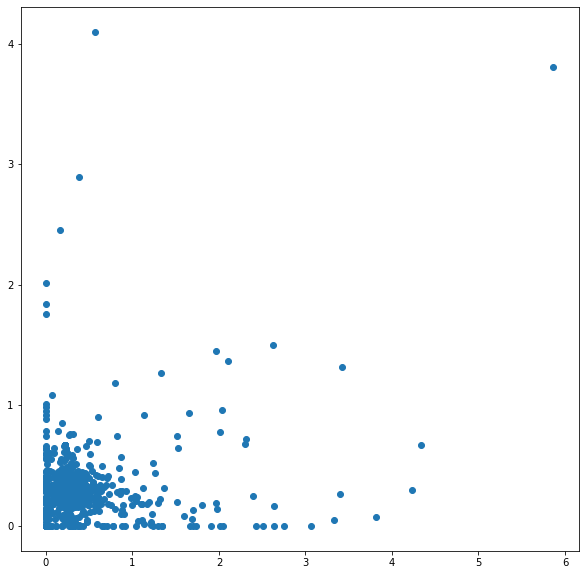

In [49]:
#n-> number of movies to plot
n=1000
#R_matrix_avg/R_matrix_value/R_matrix_orig
movie_coords,movie_ids=latent_space_proj_a1(n,R_matrix_value,unique_movies_list)
plt.figure(figsize=(10, 10))
plt.scatter(movie_coords[:,0], movie_coords[:,1])

#prints movie names on points
#for i in range(movie_coords.shape[0]):
#    for j in range(len(movie_list)):
#        if(movie_list[j][0]==str(movie_ids[i])):
#            index=j
#    plt.text(movie_coords[i][0],movie_coords[i][1],movie_list[index][1])

In [50]:
def latent_space_proj_nnmf_test(R_matrix,unique_movies_list):
    """
    Input: n-> number of movies, R_matrix, unique_movies_list
    Ouput: Returns the coords of each movie (for latent space of dim2) and the corresponding movie id
    in two separate lists
    """
    #nnmf_sk()
    #k=16
    #M,U, n_iter = non_negative_factorization(R_matrix, n_components=k,init='random', random_state=0)
    
    #nnmf()
    k=13
    M,U=nnmf(R_matrix,k)
    
    #change here the number of movies
    n=14
    movies_coords=np.zeros(shape=(n,2))
                           
    movie_ids=[]
    
    ###########################################################################
    #Defining specific movies for interpretation
    
    #sci-fi / fantasy
    #Blade Runner (1982)
    movie_ids.append(541)
    #Star Wars: Episode V - The Empire Strikes Back (1980)
    movie_ids.append(1196)
    #Matrix. The (1999)                       
    movie_ids.append(2571)
    #Lord of the Rings: The Fellowship of the Ring. The (2001)                     
    movie_ids.append(4993)
    #Lord of the Rings: The Two Towers. The (2002)                       
    movie_ids.append(5952)
    #Lord of the Rings: The Return of the King. The (2003)                       
    movie_ids.append(7153)
    
    #nonfiction
    #Dead Man Walking (1995)
    movie_ids.append(36)
    #Three Billboards Outside Ebbing. Missouri (2017)
    movie_ids.append(177593)
    
    #horror movies
    #The Shining (1997)                       
    movie_ids.append(180263)
    #Babadook. The (2014)                       
    movie_ids.append(112515)
    #Candyman: Farewell to the Flesh (1995)
    movie_ids.append(606)
    
    #dramas/romance
    #Pride and Prejudice (1995)
    movie_ids.append(7669)
    #Titanic (1997)
    movie_ids.append(1721)
    
    #comedy/animation
    #Ice Age (2002)
    movie_ids.append(5218)
    ###########################################################################
    
    
    #get indices from movie ids
    movie_index=[]
    
    for i in movie_ids:
        movie_index.append(int(np.where(unique_movies_list==i)[0]))

    j=0
    for i in movie_index:
        movies_coords[j][0]=M[i][0]
        movies_coords[j][1]=M[i][1]
        j+=1
    
    return movies_coords, movie_ids

### Plot for specific movies

Number of iterations:  69
Time taken:  4.13876748085022


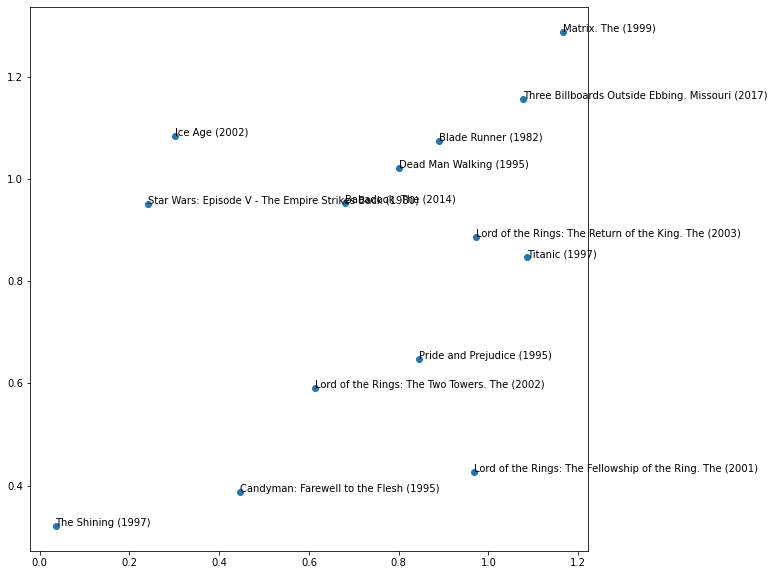

In [51]:
movie_coords,movie_ids=latent_space_proj_nnmf_test(R_matrix_avg,unique_movies_list)

plt.figure(figsize=(10, 10))
plt.scatter(movie_coords[:,0], movie_coords[:,1])

#prints movie names on points
for i in range(movie_coords.shape[0]):
    for j in range(len(movie_list)):
        if(movie_list[j][0]==str(movie_ids[i])):
            index=j
    plt.text(movie_coords[i][0],movie_coords[i][1],movie_list[index][1])

## NNALS: Factorization<a name="11"></a>

In [52]:
def NNALS(R_train,k):
    """
    Input: 
    Ouput: 
    """
    a=time.time()
    M=np.random.random((R_train.shape[0],k))
    U=np.random.random((k,R_train.shape[1]))
    err=10
    c=0
    R0=np.matmul(M,U)
    
    while (err>1):
        # Determine H by least squares, return of np.linalg.lstsq -> (x,residuals,rank,sing.values)
        U = np.linalg.lstsq(M, R_train, rcond=-1)[0]
        
        # Set negative values of H to 0
        U[U<0]=0
        
        # Determine W by least squares
        M = np.linalg.lstsq(U.T, R_train.T, rcond=-1)[0].T
        
        # Set negative values of W to 0
        M[M<0]=0
        
        R1=np.matmul(M,U)
        err=np.linalg.norm(np.subtract(R0,R1),ord='fro')
        R0=R1
        c+=1
        
    b=time.time()-a
    print("Number of iterations: ", c)
    print("Time taken: ", b)
    
    return M, U

## NNALS: Recontruction Errors<a name="12"></a>

In [53]:
def NNALS_comparison(R_matrix,R_train,R_test,l=0.1):
    """
    Input: 
    Ouput:
    """

    als_dict1 = {}
    als_dict2 = {}
    
    #Change ord for different norms
    
    for i in range(1,50,1):
        M,U=NNALS(train_set_matrix,i)
        R_approx=np.matmul(M,U)
        x=np.linalg.norm(np.subtract(R_approx,R_matrix),ord='fro')
        R_approx_comp=build_comparison_matrices(R_approx,R_test)
        y=np.linalg.norm(np.subtract(R_approx_comp,R_test),ord='fro')   
        als_dict1[i] = round(x,1)
        als_dict2[i] = round(y,1)
        print("Rank k =",i,"done.")
        print("---------------")
        
    for i in range(50,310,10):
        M,U=NNALS(train_set_matrix,i)
        R_approx=np.matmul(M,U)
        x=np.linalg.norm(np.subtract(R_approx,R_matrix),ord='fro')
        R_approx_comp=build_comparison_matrices(R_approx,R_test)
        y=np.linalg.norm(np.subtract(R_approx_comp,R_test),ord='fro')   
        als_dict1[i] = round(x,1)
        als_dict2[i] = round(y,1)
        print("Rank k =",i,"done.")
        print("---------------")
    
    return als_dict1, als_dict2

### Remove comments on the following two code cells to compute plots

In [54]:
#als_dict1,als_dict2=NNALS_comparison(R_matrix_value,train_set_matrix,test_set_matrix)
#print("Norm min for test:","k=", min(als_dict2, key=als_dict2.get), " norm=", als_dict2[min(als_dict2, key=als_dict2.get)])

In [55]:
##plot specifications
#x=list(als_dict1.keys())
#y=list(als_dict1.values())
#print("Norm min for test:","k=", min(als_dict2, key=als_dict2.get), " norm=", als_dict2[min(als_dict2, key=als_dict2.get)])
#plt.figure(figsize=(20, 10))
#plt.plot(x, y)
#plt.xlabel('rank(k)')  # Add an x-label to the axes.
#plt.xticks(np.arange(min(x)-1, 620, 20.0))
#plt.ylabel('Norm(k)')  # Add a y-label to the axes.
#plt.title("Nuclear norm as a function of rank")  # Add a title to the axes.
##plt.title("Nuclear norm as a function of rank")  # Add a title to the axes.
#x=list(als_dict2.keys())
#y=list(als_dict2.values())
#plt.plot(x, y)

## NNALS: Recommendation System<a name="13"></a>

In [56]:
def recommend_movies_based_on_movie_nnals(movie_id,R_matrix,unique_movies_list):
    """
    Input: movie_id we want to compare, R_matrix, list with index-movie id correspondence
    Ouput: None, however the function prints the top 10 results similar to movie id
    """
    
    k=9
    M,U=NNALS(R_matrix,k)
    
    sim = np.zeros(shape=(num_movie_ids,2))
    movie_id_index=np.where(unique_movies_list==movie_id)
    movie_id_index=int(movie_id_index[0])
    
    for i in range(num_movie_ids):
        sim[i][0]=cosine_sim(M[movie_id_index,:],M[i,:])
        sim[i][1]=unique_movies_list[i]
    
    #sorts from lowest to highest
    sim=sim[sim[:, 0].argsort()]
    
    for i in range(len(movie_list)):
        if(int(movie_list[i][0])==movie_id):
            print("\nRecommendations similar to:", movie_list[i][1])
    
    for i in range(11):
        for j in range(len(movie_list)):
            #we use sim.shape[0]-(1+i) because sort was lost to high
            if(int(sim[sim.shape[0]-(1+i)][1])== int(movie_list[j][0])):
                if(i==0):
                    print("")
                    #print("Printing highest to confirm it's working as intended:",movie_list[j][1],"Similarity:", np.round(sim[sim.shape[0]-(1+i)][0],2))
                elif (i>0):
                    print(i,')', movie_list[j][1],"Similarity:", np.round(sim[sim.shape[0]-(1+i)][0],10))
    return sim

In [57]:
#Lord of the Rings: The Fellowship of the Ring
sim=recommend_movies_based_on_movie_nnals(4993,R_matrix_value,unique_movies_list)

Number of iterations:  102
Time taken:  18.835147857666016

Recommendations similar to: Lord of the Rings: The Fellowship of the Ring. The (2001)

1 ) Matrix Reloaded. The (2003) Similarity: 0.9973137231
2 ) Bourne Supremacy. The (2004) Similarity: 0.996589979
3 ) Island. The (2005) Similarity: 0.9955285957
4 ) Equilibrium (2002) Similarity: 0.9952933172
5 ) Collateral (2004) Similarity: 0.9947232648
6 ) Last Samurai. The (2003) Similarity: 0.9945244622
7 ) Red Dragon (2002) Similarity: 0.9938100466
8 ) Boondock Saints. The (2000) Similarity: 0.9934267479
9 ) Black Hawk Down (2001) Similarity: 0.9929337124
10 ) Cube (1997) Similarity: 0.9928832699


In [58]:
def recommend_movies_based_on_user_nnals(user_id,R_matrix,unique_movies_list):
    """
    Input: user_id we want to predict ratings, R_matrix, list with index-movie id correspondence
    Ouput: None, however the function prints the top 10 movies for user with user_id
    """
    
    k=9
    M,U,=NNALS(R_matrix,k)
    
    Rk=np.matmul(M,U)
    
    #2d list with ratings obtained from Rk and corresponding movie index
    ratings_movieid=np.zeros(shape=(num_movie_ids,2))
    
    for i in range(num_movie_ids):
        #record only unseen movies, i.e. 0 rating on original R matrix
        if(R_matrix_orig[i][user_id-1]==0):
            ratings_movieid[i][0]=Rk[i][user_id-1]
            #getting movie id from index using unique_movies_list
            ratings_movieid[i][1]=unique_movies_list[i]
    
    ratings_movieid=ratings_movieid[ratings_movieid[:, 0].argsort()]
    
    print("\nExpected ratings for user:",user_id)
    
    for i in range(10):
        for j in range(len(movie_list)):
            if(int(ratings_movieid[ratings_movieid.shape[0]-(i+1)][1])== int(movie_list[j][0])):     
                print(i+1,':', movie_list[j][1], "-> Expected rating:",np.round(ratings_movieid[ratings_movieid.shape[0]-(i+1)][0],2))
                
    return None

In [59]:
#user 134
recommend_movies_based_on_user_nnals(134,R_matrix_avg,unique_movies_list)

Number of iterations:  656
Time taken:  118.16658997535706

Expected ratings for user: 134
1 : Shawshank Redemption. The (1994) -> Expected rating: 4.43
2 : Streetcar Named Desire. A (1951) -> Expected rating: 4.27
3 : Departed. The (2006) -> Expected rating: 4.26
4 : Godfather. The (1972) -> Expected rating: 4.26
5 : Princess Bride. The (1987) -> Expected rating: 4.24
6 : Fight Club (1999) -> Expected rating: 4.24
7 : Forrest Gump (1994) -> Expected rating: 4.23
8 : Schindler's List (1993) -> Expected rating: 4.22
9 : Dark Knight. The (2008) -> Expected rating: 4.22
10 : Casablanca (1942) -> Expected rating: 4.22


## NNALS: Latent Space Projections<a name="14"></a>

In [60]:
def latent_space_proj_nnals(n,R_matrix,unique_movies_list):
    """
    Input: n-> number of movies, R_matrix, unique_movies_list
    Ouput: Returns the coords of each movie (for latent space of dim2) and the corresponding movie id
    in two separate lists
    """
    
    #x-coordinate sigma1
    #y-coordinate sigma2

    k=9
    M,U=NNALS(R_matrix,k)
    
    #generate indices of movies
    l=np.arange(0,num_movie_ids)
    l=np.ndarray.tolist(l)
    
    #contains the coords of 100 movies
    movies_coords=np.zeros(shape=(n,2))
    
    #Draw n random movies
    movie_indices=random.sample(l,n)

    movie_indices.sort()
    
    j=0
    for i in movie_indices:
        movies_coords[j][0]=M[i][0]
        movies_coords[j][1]=M[i][1]
        j+=1
        
    #recover movie ids from indices
    movie_ids=[]
    for i in movie_indices:
        movie_ids.append(unique_movies_list[i])
        
    return movies_coords, movie_ids

### Plot for random movies

Number of iterations:  62
Time taken:  10.799883365631104


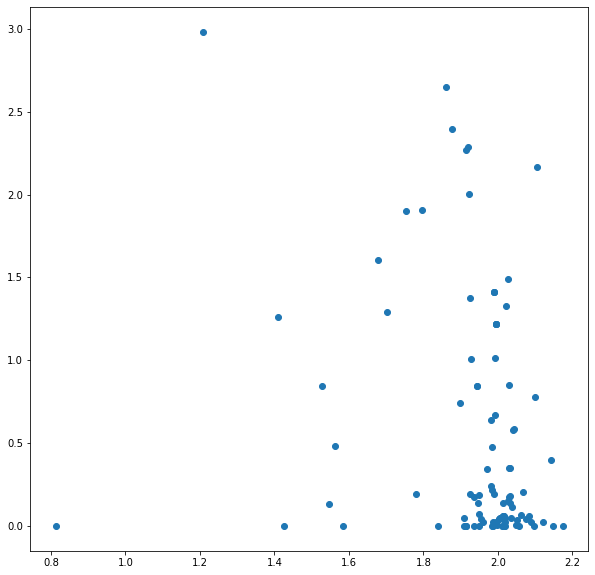

In [61]:
#n-> number of movies to plot
n=100
#R_matrix_avg/R_matrix_value/R_matrix_orig
movie_coords,movie_ids=latent_space_proj_nnals(n,R_matrix_value,unique_movies_list)
plt.figure(figsize=(10, 10))
plt.scatter(movie_coords[:,0], movie_coords[:,1])

#prints movie names on points
#for i in range(movie_coords.shape[0]):
#    for j in range(len(movie_list)):
#        if(movie_list[j][0]==str(movie_ids[i])):
#            index=j
#    plt.text(movie_coords[i][0],movie_coords[i][1],movie_list[index][1])

In [62]:
def latent_space_proj_nnals_test(R_matrix,unique_movies_list):
    """
    Input: n-> number of movies, R_matrix, unique_movies_list
    Ouput: Returns the coords of each movie (for latent space of dim2) and the corresponding movie id
    in two separate lists
    """

    k=9
    M,U=NNALS(R_matrix,k)
    
    #change here the number of movies
    n=14
    movies_coords=np.zeros(shape=(n,2))
                           
    movie_ids=[]
    
    ###########################################################################
    #Defining specific movies for interpretation
    
    #sci-fi / fantasy
    #Blade Runner (1982)
    movie_ids.append(541)
    #Star Wars: Episode V - The Empire Strikes Back (1980)
    movie_ids.append(1196)
    #Matrix. The (1999)                       
    movie_ids.append(2571)
    #Lord of the Rings: The Fellowship of the Ring. The (2001)                     
    movie_ids.append(4993)
    #Lord of the Rings: The Two Towers. The (2002)                       
    movie_ids.append(5952)
    #Lord of the Rings: The Return of the King. The (2003)                       
    movie_ids.append(7153)
    
    #nonfiction
    #Dead Man Walking (1995)
    movie_ids.append(36)
    #Three Billboards Outside Ebbing. Missouri (2017)
    movie_ids.append(177593)
    
    #horror movies
    #The Shining (1997)                       
    movie_ids.append(180263)
    #Babadook. The (2014)                       
    movie_ids.append(112515)
    #Candyman: Farewell to the Flesh (1995)
    movie_ids.append(606)
    
    #dramas/romance
    #Pride and Prejudice (1995)
    movie_ids.append(7669)
    #Titanic (1997)
    movie_ids.append(1721)
    
    #comedy/animation
    #Ice Age (2002)
    movie_ids.append(5218)
    ###########################################################################
    
    
    #get indices from movie ids
    movie_index=[]
    
    for i in movie_ids:
        movie_index.append(int(np.where(unique_movies_list==i)[0]))

    j=0
    for i in movie_index:
        movies_coords[j][0]=M[i][0]
        movies_coords[j][1]=M[i][1]
        j+=1
    
    return movies_coords, movie_ids

### Plot for specific movies

Number of iterations:  94
Time taken:  16.574142456054688


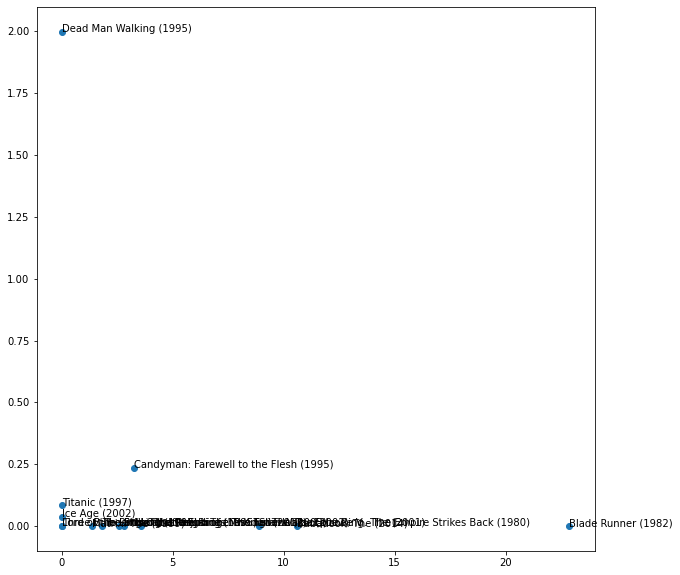

In [64]:
movie_coords,movie_ids=latent_space_proj_nnals_test(R_matrix_value,unique_movies_list)

plt.figure(figsize=(10, 10))
plt.scatter(movie_coords[:,0], movie_coords[:,1])

#prints movie names on points
for i in range(movie_coords.shape[0]):
    for j in range(len(movie_list)):
        if(movie_list[j][0]==str(movie_ids[i])):
            index=j
    plt.text(movie_coords[i][0],movie_coords[i][1],movie_list[index][1])